In [1]:
import string

import pandas as pd
import numpy as np
import seaborn as sns
import nltk
import re
import matplotlib.pyplot as plt

from ydata_profiling import ProfileReport
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from nltk import tokenize
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold
from transformers import pipeline
%matplotlib inline

C:\Users\Andrii\anaconda3\envs\IASA-NLP-Homework\Lib\site-packages\numba\core\decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
C:\Users\Andrii\anaconda3\envs\IASA-NLP-Homework\Lib\site-packages\visions\backends\shared\nan_handling.py:50: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @nb.jit


In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('brown')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Andrii\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Andrii\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\Andrii\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [4]:
prompts_train = pd.read_csv('../data/prompts_train.csv')
summaries_train = pd.read_csv('../data/summaries_train.csv')

In [5]:
prompts_train.head()

,prompt_id,prompt_question,prompt_title,prompt_text
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...
1,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
2,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
3,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an..."


In [6]:
summaries_train.head()

,student_id,prompt_id,text,content,wording
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757


**Dataset Description**
The dataset comprises about 24,000 summaries written by students in grades 3-12 of passages on a variety of topics and genres. These summaries have been assigned scores for both content and wording. The goal of the competition is to predict content and wording scores for summaries on unseen topics.

**File and Field Information**
`summaries_train.csv` - Summaries in the training set.
 - `student_id` - The ID of the student writer.
 - `prompt_id` - The ID of the prompt which links to the prompt file.
 - `text` - The full text of the student's summary.
 - `content` - The content score for the summary. The first target.
 - `wording` - The wording score for the summary. The second target.

`prompts_train.csv` - The four training set prompts. Each prompt comprises the complete summarization assignment given to students.
 - `prompt_id` - The ID of the prompt which links to the summaries file.
 - `prompt_question` - The specific question the students are asked to respond to.
 - `prompt_title` - A short-hand title for the prompt.
 - `prompt_text` - The full prompt text.

In [7]:
summaries_train.prompt_id.unique()

array(['814d6b', 'ebad26', '3b9047', '39c16e'], dtype=object)

In [8]:
summaries_train.dtypes

student_id     object
prompt_id      object
text           object
content       float64
wording       float64
dtype: object

In [9]:
summaries_train['student_id'].unique().shape

(7165,)

In [10]:
summaries_train.shape

(7165, 5)

# Preprocessing
Here we have simple text preprocessing and also we form special column witch includes all: summary text, prompt title, prompt question, prompt text.

In [11]:
def clear_text(text, stopwords=None):
    text = text.replace('\n', '').replace('\r', '').replace('\t', '')
    text = text.lower()
    text = re.sub(r"[^\w\s']+", '', text)

    if stopwords is not None:
        text = re.sub(rf'\b(?:{"|".join(stopwords)})\b', '', text)

    text = re.sub(rf'\s+', ' ', text)
    return text

In [12]:
summaries_train['clean_text'] = summaries_train['text'].apply(clear_text)
df = summaries_train.merge(prompts_train, how='left', on='prompt_id')
df['general_prompt'] = (
        'Summary: ' + df['text'] + 
        '. Title: ' + df['prompt_title'] +
        '. Question: ' + df['prompt_question'] +
        '. Text: ' + df['prompt_text']
    
)
df['clean_general_prompt'] = df['general_prompt'].apply(clear_text)

df.head()

,student_id,prompt_id,text,content,wording,clean_text,prompt_question,prompt_title,prompt_text,general_prompt,clean_general_prompt
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,the third wave was an experimentto see how peo...,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,Summary: The third wave was an experimentto se...,summary the third wave was an experimentto see...
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,they would rub it up with soda to make the sme...,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an...",Summary: They would rub it up with soda to mak...,summary they would rub it up with soda to make...
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,in egypt there were many occupations and socia...,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,"Summary: In Egypt, there were many occupations...",summary in egypt there were many occupations a...
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,the highest class was pharaohs these people we...,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,Summary: The highest class was Pharaohs these ...,summary the highest class was pharaohs these p...
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,the third wave developed rapidly because the s...,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,Summary: The Third Wave developed rapidly bec...,summary the third wave developed rapidly becau...


# Setup utils
Below we load GloVe vocabulary and surround it with scikit-learn interface.

In [13]:
from contextlib import redirect_stdout, contextmanager
import os

import gensim.downloader as api


@contextmanager
def suppress():
    with open(os.devnull, "w") as null:
        with redirect_stdout(null):
            yield

with suppress():
    glove_model = api.load("glove-wiki-gigaword-300")

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin


class EmbeddingVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, model, stop_words=None):
        self.model = model
        self.stop_words = stop_words or []

    def transform(self, X):
        X = [
            np.sum(
                [
                    self.model[token] for token in tokenize.word_tokenize(el) if
                    token in self.model and token not in self.stop_words
                ],
                axis=0
            ).reshape(1, -1) for el in X
        ]
        X = np.concatenate(X, axis=0)
        return X

    def fit(self, X, y=None):
        return self

Also, we define the MCRMSE error and score functions, which used to evaluate LB score.

In [15]:
def mcrmse_error(y_true, y_pred):
    error = (y_true - y_pred) ** 2
    error = np.sqrt(error.mean(axis=0)).mean()
    return error


def mcrmse_score(y_true, y_pred):
    return -mcrmse_error(y_true, y_pred)

# Validation

Function to calculate cross-validation scores.

In [16]:
def evaluate_model(model, X, X_test, y, y_test, cv):
    scores = []
    
    for train_ind, test_ind in cv:
        X_train, X_val = X.iloc[train_ind], X.iloc[test_ind]
        y_train, y_val = y.iloc[train_ind], y.iloc[test_ind]
        model.fit(X_train, y_train)
        y_hat = model.predict(X_val)
        scores.append(
            mcrmse_error(y_val.to_numpy(), y_hat)
        )

    scores = np.array(scores)
    avg_score = round(scores.mean(), 4)
    std_score = round(scores.std(), 4)
    min_score = round(scores.min(), 4)
    max_score = round(scores.max(), 4)
    score_lower_bound = round(avg_score - 3 * std_score, 4)
    score_higher_bound = round(avg_score + 3 * std_score, 4)

    model.fit(X, y)
    unseen_error = mcrmse_error(y_test, model.predict(X_test))

    results = {
            'experiment': model_name,
            'mcrmse_avg': avg_score,
            'mcrmse_std': std_score,
            'mcrmse_min': min_score,
            'mcrmse_max': max_score,
            'mcrmse_lower_bound_estimation': score_lower_bound,
            'mcrmse_higher_bound_estimation': score_higher_bound,
            'mcrmse_on_unseen_data': unseen_error
        }
    return results

## Only text

Here we setup models to validate on clean summary text.

In [17]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import Ridge

models = {
    'BoW': Pipeline(
        [
            ('vectorizer', CountVectorizer(
                analyzer='word',
                stop_words=[],
                ngram_range=(1, 3),
                lowercase=True,
                max_features=30000
            )),
            ('regressor', Ridge())
        ]
    ),
    'Tf_IDF': Pipeline(
        [
            ('vectorizer', TfidfVectorizer(
                analyzer='word',
                stop_words=[],
                ngram_range=(1, 3),
                lowercase=True,
                max_features=30000
            )),
            ('regressor', Ridge())
        ]
    ),
    'GloVe': Pipeline(
        [
            ('vectorizer', EmbeddingVectorizer(glove_model)),
            ('regressor', Ridge())
        ]
    ),
}

Private LB scores of the models mentioned above:

In [18]:
base_results_text = {
    'BoW': 1.036,
    'Tf_IDF': 0.782,
    'GloVe': 0.749,
}

### K-fold Validation

In [19]:
from sklearn.model_selection import train_test_split

train, test  = train_test_split(df, test_size=.2, random_state=42)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

train.shape, test.shape

((5732, 11), (1433, 11))

In [20]:
from sklearn.model_selection import KFold

targets = ['content', 'wording']
kfold_results = []
column = 'clean_text'

for model_name, model in models.items():
    X_train, X_test, y_train, y_test = train[column], test[column], train[targets], test[targets]
    
    cv = KFold(7, shuffle=True, random_state=42)
    cv = cv.split(X_train, y_train)
    
    result = evaluate_model(model, X_train, X_test, y_train, y_test, cv)
    result['experiment'] = model_name
    kfold_results.append(result)

kfold_results = pd.DataFrame(kfold_results).sort_values('mcrmse_avg')
kfold_results = kfold_results.set_index(kfold_results['experiment']).drop(columns=['experiment'])
kfold_results

,mcrmse_avg,mcrmse_std,mcrmse_min,mcrmse_max,mcrmse_lower_bound_estimation,mcrmse_higher_bound_estimation,mcrmse_on_unseen_data
experiment,,,,,,,
Tf_IDF,0.5907,0.0147,0.5691,0.6149,0.5466,0.6348,0.567816
GloVe,0.6622,0.0204,0.6323,0.7024,0.6010,0.7234,0.647860
BoW,0.7530,0.0168,0.7296,0.7776,0.7026,0.8034,0.756395


### Group K-fold
This algorithm implements Group K-fold validation with train/val/test dataset split. In the beginning we iterate through the prompts ids. Then use all summaries with prompt we are current at as test dataset and other 3 prompts we use for Group K-fold validation to get model's statistics (mean, std, min, max, ...). Afterward, we map these all models statistics to current prompt id.  

In [21]:
from sklearn.model_selection import GroupKFold
group_results = {}


for prompt_id in df['prompt_id'].unique():
    train, test = df[df['prompt_id'] != prompt_id], df[df['prompt_id'] == prompt_id]
    train = train.reset_index(drop=True)
    test = test.reset_index(drop=True)


    results = []
    for model_name, model in models.items():
        X_train, X_test, y_train, y_test = train[column], test[column], train[targets], test[targets]
    
        cv = GroupKFold(3)
        cv = cv.split(X_train, y_train, train['prompt_id'])
    
        result = evaluate_model(model, X_train, X_test, y_train, y_test, cv)
        result['experiment'] = model_name
        results.append(result)
    
    group_results[prompt_id] = results

Below we form DataFrame with all results limited to Group K-fold models validation.

In [22]:
from collections import defaultdict

indexes = []
values = defaultdict(list)
for prompt_id, group in group_results.items():
    for experiment in group:
        indexes.append((experiment['experiment'], prompt_id))
        for key, item in list(experiment.items())[1:]:
            values[key].append(item)
        

In [23]:
group_results = pd.DataFrame(values, index=pd.MultiIndex.from_tuples(indexes))
group_results

,,mcrmse_avg,mcrmse_std,mcrmse_min,mcrmse_max,mcrmse_lower_bound_estimation,mcrmse_higher_bound_estimation,mcrmse_on_unseen_data
BoW,814d6b,0.9981,0.0521,0.9256,1.0461,0.8418,1.1544,1.294896
Tf_IDF,814d6b,0.8948,0.0197,0.8685,0.9159,0.8357,0.9539,0.829852
GloVe,814d6b,1.1084,0.1394,0.9314,1.2721,0.6902,1.5266,1.200049
BoW,ebad26,1.1116,0.1535,0.9666,1.3240,0.6511,1.5721,0.955557
Tf_IDF,ebad26,0.8797,0.0469,0.8349,0.9444,0.7390,1.0204,1.019488
GloVe,ebad26,1.0462,0.1751,0.8739,1.2865,0.5209,1.5715,0.933407
BoW,3b9047,1.0755,0.0752,0.9827,1.1670,0.8499,1.3011,1.044651
Tf_IDF,3b9047,0.9437,0.1902,0.7994,1.2124,0.3731,1.5143,0.921144
GloVe,3b9047,1.2689,0.1115,1.1172,1.3818,0.9344,1.6034,0.872884
BoW,39c16e,1.1088,0.1858,0.9074,1.3557,0.5514,1.6662,1.077608


### Results

In [24]:
unseen = pd.DataFrame(base_results_text.values(), columns=['LB'], index=base_results_text.keys())
unseen

,LB
BoW,1.036
Tf_IDF,0.782
GloVe,0.749


In [25]:
unseen = (unseen
    .join(kfold_results['mcrmse_on_unseen_data'])
    .join(group_results.groupby(level=0)['mcrmse_on_unseen_data'].mean(), rsuffix='_group')
    .join(group_results.swaplevel(0, 1).loc['39c16e', 'mcrmse_on_unseen_data'], rsuffix='_39c16e')
    .join(group_results.swaplevel(0, 1).loc['3b9047', 'mcrmse_on_unseen_data'], rsuffix='_3b9047')
    .join(group_results.swaplevel(0, 1).loc['814d6b', 'mcrmse_on_unseen_data'], rsuffix='_814d6b')
    .join(group_results.swaplevel(0, 1).loc['ebad26', 'mcrmse_on_unseen_data'], rsuffix='_ebad26')
    .join(kfold_results['mcrmse_avg'])
    .join(group_results.groupby(level=0)['mcrmse_avg'].mean(), rsuffix='_group')
    .join(group_results.swaplevel(0, 1).loc['39c16e', 'mcrmse_avg'], rsuffix='_39c16e')
    .join(group_results.swaplevel(0, 1).loc['3b9047', 'mcrmse_avg'], rsuffix='_3b9047')
    .join(group_results.swaplevel(0, 1).loc['814d6b', 'mcrmse_avg'], rsuffix='_814d6b')
    .join(group_results.swaplevel(0, 1).loc['ebad26', 'mcrmse_avg'], rsuffix='_ebad26')
 )
unseen

,LB,mcrmse_on_unseen_data,mcrmse_on_unseen_data_group,mcrmse_on_unseen_data_39c16e,mcrmse_on_unseen_data_3b9047,mcrmse_on_unseen_data_814d6b,mcrmse_on_unseen_data_ebad26,mcrmse_avg,mcrmse_avg_group,mcrmse_avg_39c16e,mcrmse_avg_3b9047,mcrmse_avg_814d6b,mcrmse_avg_ebad26
BoW,1.036,0.756395,1.093178,1.077608,1.044651,1.294896,0.955557,0.7530,1.073500,1.1088,1.0755,0.9981,1.1116
Tf_IDF,0.782,0.567816,0.915825,0.892815,0.921144,0.829852,1.019488,0.5907,0.914275,0.9389,0.9437,0.8948,0.8797
GloVe,0.749,0.647860,1.010507,1.035686,0.872884,1.200049,0.933407,0.6622,1.133050,1.1087,1.2689,1.1084,1.0462


Abow we form DataFrame with results we got for each validation strategies for all models. 
  - `LB`: private LB scores of the models
  - `mcrmse_on_unseen_data`: mcrmse error on test dataset we used in simple K-fold validation
  - `mcrmse_on_unseen_data_group`: average mcrmse error on test datasets we used in Group K-fold validation
  - `mcrmse_on_unseen_data_'prompt_id'`: mcrmse error of models when we used 'prompt_id' summaries as test dataset
  - `mcrmse_avg`: mean mcrmse error on val datasets through all folds in simple K-fold validation
  - `mcrmse_avg_group`: mean mcrmse error on all val datasets we used in Group K-fold validation
  - `mcrmse_avg_'prompt_id'`: mean mcrmse error on val datasets through all folds in Group k-fold validation when 'prompt_id' summaries used as test dataset.
 

<Axes: >

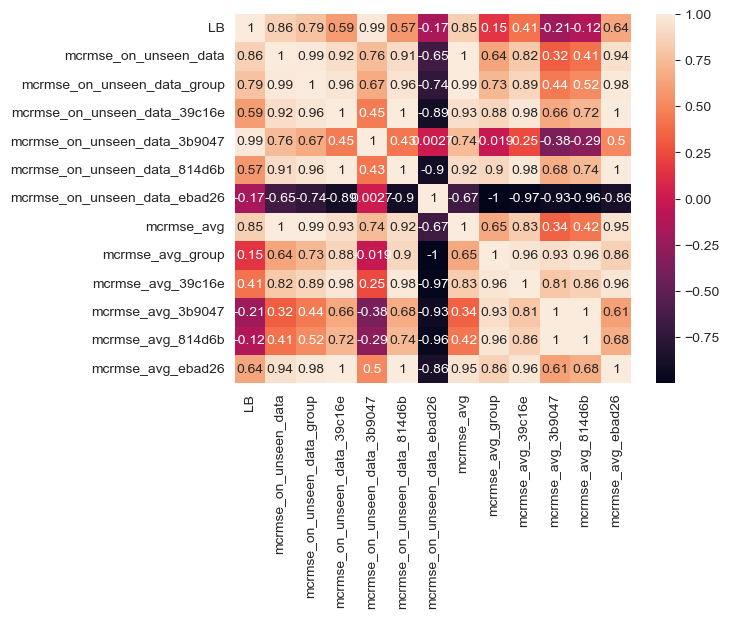

In [26]:
import seaborn as sns
sns.heatmap(unseen.corr(), annot=True)

As we can see from correlation matrix, there is strong positive correlation between LB score and `mcrmse_on_unseen_data` (0.86), `mcrmse_avg` (0.85). We can suggest that it is possible to use simple K-fold validation to compare our models when we only use cleaned summary text to make predictions.

## Text with prompt
Here we setup models to validate on `clean_general_prompt` (we add stopwords processing to pipelines).

In [27]:
models = {
    'BoW': Pipeline(
        [
            ('vectorizer', CountVectorizer(
                analyzer='word',
                stop_words='english',
                ngram_range=(1, 3),
                lowercase=True,
                max_features=30000
            )),
            ('regressor', Ridge())
        ]
    ),
    'Tf_IDF': Pipeline(
        [
            ('vectorizer', TfidfVectorizer(
                analyzer='word',
                stop_words='english',
                ngram_range=(1, 3),
                lowercase=True,
                max_features=30000
            )),
            ('regressor', Ridge())
        ]
    ),
    'GloVe': Pipeline(
        [
            ('vectorizer', EmbeddingVectorizer(glove_model, nltk.corpus.stopwords.words('english'))),
            ('regressor', Ridge())
        ]
    ),
}

Private LB scores of the models mentioned above:

In [28]:
base_results_prompt = {
    'BoW': 3.317,
    'Tf_IDF': 7.091,
    'GloVe': 2.52,
}

Further, we perform same actions as previous.

### KFold

In [29]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=.2, random_state=42)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

train.shape, test.shape

((5732, 11), (1433, 11))

In [30]:
from sklearn.model_selection import KFold

kfold_results = []
column = 'clean_general_prompt'
for model_name, model in models.items():
    X_train, X_test, y_train, y_test = train[column], test[column], train[targets], test[targets]

    cv = KFold(7, shuffle=True, random_state=42)
    cv = cv.split(X_train, y_train)

    result = evaluate_model(model, X_train, X_test, y_train, y_test, cv)
    result['experiment'] = model_name
    kfold_results.append(result)

kfold_results = pd.DataFrame(kfold_results).sort_values('mcrmse_avg')
kfold_results = kfold_results.set_index(kfold_results['experiment']).drop(columns=['experiment'])
kfold_results


,mcrmse_avg,mcrmse_std,mcrmse_min,mcrmse_max,mcrmse_lower_bound_estimation,mcrmse_higher_bound_estimation,mcrmse_on_unseen_data
experiment,,,,,,,
GloVe,0.6696,0.0162,0.6400,0.6957,0.6210,0.7182,0.649944
Tf_IDF,0.6762,0.0222,0.6264,0.6991,0.6096,0.7428,0.654514
BoW,0.7239,0.0230,0.6879,0.7611,0.6549,0.7929,0.748144


### Group KFold 

In [31]:
from sklearn.model_selection import GroupKFold

group_results = {}

for prompt_id in df['prompt_id'].unique():
    train, test = df[df['prompt_id'] != prompt_id], df[df['prompt_id'] == prompt_id]
    train = train.reset_index(drop=True)
    test = test.reset_index(drop=True)

    results = []
    for model_name, model in models.items():
        X_train, X_test, y_train, y_test = train[column], test[column], train[targets], test[targets]

        cv = GroupKFold(3)
        cv = cv.split(X_train, y_train, train['prompt_id'])

        result = evaluate_model(model, X_train, X_test, y_train, y_test, cv)
        result['experiment'] = model_name
        results.append(result)

    group_results[prompt_id] = results

In [32]:
from collections import defaultdict

indexes = []
values = defaultdict(list)
for prompt_id, group in group_results.items():
    for experiment in group:
        indexes.append((experiment['experiment'], prompt_id))
        for key, item in list(experiment.items())[1:]:
            values[key].append(item)

In [33]:
group_results = pd.DataFrame(values, index=pd.MultiIndex.from_tuples(indexes))
group_results

,,mcrmse_avg,mcrmse_std,mcrmse_min,mcrmse_max,mcrmse_lower_bound_estimation,mcrmse_higher_bound_estimation,mcrmse_on_unseen_data
BoW,814d6b,3.9391,0.6861,3.3463,4.9007,1.8808,5.9974,3.532276
Tf_IDF,814d6b,5.7861,0.3132,5.4444,6.2011,4.8465,6.7257,6.323739
GloVe,814d6b,3.8689,1.2424,2.1241,4.9200,0.1417,7.5961,2.319846
BoW,ebad26,3.8359,0.4357,3.2199,4.1581,2.5288,5.1430,3.520340
Tf_IDF,ebad26,5.8183,0.3599,5.3677,6.2485,4.7386,6.8980,6.663981
GloVe,ebad26,2.6913,0.9227,2.0248,3.9961,-0.0768,5.4594,4.306397
BoW,3b9047,3.4783,0.3626,2.9656,3.7459,2.3905,4.5661,4.800804
Tf_IDF,3b9047,6.2447,0.4498,5.6145,6.6353,4.8953,7.5941,7.201743
GloVe,3b9047,6.0414,2.8808,3.7161,10.1012,-2.6010,14.6838,1.742691
BoW,39c16e,4.0391,0.2153,3.8148,4.3296,3.3932,4.6850,4.090154


### Results

In [34]:
unseen = pd.DataFrame(base_results_prompt.values(), columns=['LB'], index=base_results_prompt.keys())
unseen

,LB
BoW,3.317
Tf_IDF,7.091
GloVe,2.520


In [35]:
unseen = (unseen
          .join(kfold_results['mcrmse_on_unseen_data'])
          .join(group_results.groupby(level=0)['mcrmse_on_unseen_data'].mean(), rsuffix='_group')
          .join(group_results.swaplevel(0, 1).loc['39c16e', 'mcrmse_on_unseen_data'], rsuffix='_39c16e')
          .join(group_results.swaplevel(0, 1).loc['3b9047', 'mcrmse_on_unseen_data'], rsuffix='_3b9047')
          .join(group_results.swaplevel(0, 1).loc['814d6b', 'mcrmse_on_unseen_data'], rsuffix='_814d6b')
          .join(group_results.swaplevel(0, 1).loc['ebad26', 'mcrmse_on_unseen_data'], rsuffix='_ebad26')
          .join(kfold_results['mcrmse_avg'])
          .join(group_results.groupby(level=0)['mcrmse_avg'].mean(), rsuffix='_group')
          .join(group_results.swaplevel(0, 1).loc['39c16e', 'mcrmse_avg'], rsuffix='_39c16e')
          .join(group_results.swaplevel(0, 1).loc['3b9047', 'mcrmse_avg'], rsuffix='_3b9047')
          .join(group_results.swaplevel(0, 1).loc['814d6b', 'mcrmse_avg'], rsuffix='_814d6b')
          .join(group_results.swaplevel(0, 1).loc['ebad26', 'mcrmse_avg'], rsuffix='_ebad26')
          )
unseen

,LB,mcrmse_on_unseen_data,mcrmse_on_unseen_data_group,mcrmse_on_unseen_data_39c16e,mcrmse_on_unseen_data_3b9047,mcrmse_on_unseen_data_814d6b,mcrmse_on_unseen_data_ebad26,mcrmse_avg,mcrmse_avg_group,mcrmse_avg_39c16e,mcrmse_avg_3b9047,mcrmse_avg_814d6b,mcrmse_avg_ebad26
BoW,3.317,0.748144,3.985894,4.090154,4.800804,3.532276,3.520340,0.7239,3.82310,4.0391,3.4783,3.9391,3.8359
Tf_IDF,7.091,0.654514,6.726740,6.717495,7.201743,6.323739,6.663981,0.6762,5.97320,6.0437,6.2447,5.7861,5.8183
GloVe,2.520,0.649944,2.971818,3.518337,1.742691,2.319846,4.306397,0.6696,4.10765,3.8290,6.0414,3.8689,2.6913


<Axes: >

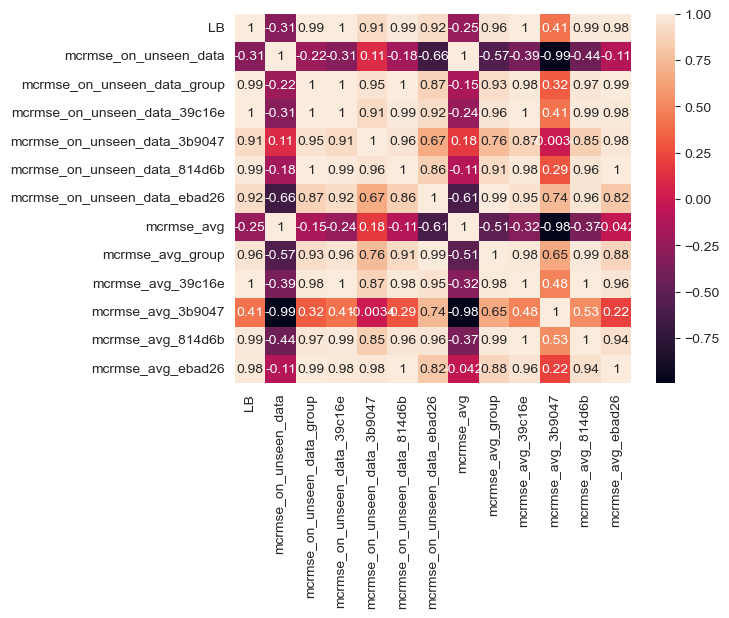

In [36]:
import seaborn as sns

sns.heatmap(unseen.corr(), annot=True)

As we can see from correlation matrix, there is very strong positive correlation between LB score and `mcrmse_on_unseen_data_group` (0.99), `mcrmse_avg_group` (0.96). We can suggest that we should use Group K-fold validation strategy that was described above to compare our models when we use both cleaned summary text and information from prompts to make predictions.